# Logistic Regression 

In [15]:
# Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

In [29]:
# Baseline without CV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss

# Primary Type
lr_primary = LogisticRegression(max_iter=1000)
lr_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = lr_primary.predict(X_test_scaled)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
lr_both = MultiOutputClassifier(LogisticRegression(max_iter=1000))
lr_both.fit(X_train_scaled, y_train_both_bin)
y_pred_both = lr_both.predict(X_test_scaled)
print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Generation
lr_generation = LogisticRegression(max_iter=1000)
lr_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = lr_generation.predict(X_test_scaled)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Logistic Regression - Primary Type Accuracy: 0.23902439024390243
Logistic Regression - Both Types Hamming Loss: 0.08373983739837398
Logistic Regression - Generation Accuracy: 0.2


In [17]:
# Model Implementation
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Primary Type Prediction
lr_primary = LogisticRegression(max_iter=1000)

# Both Types Prediction
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Generation Prediction
lr_generation = LogisticRegression(max_iter=1000)

In [25]:
# suppress convergence warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

EXAMPLE: The mean CV score of 0.213 is likely the average accuracy across the 5 folds of cross-validation. This indicates that, on average, the model correctly predicts the primary type for about 21.3% of the Pokémon in the validation sets.

In [ ]:
# Results
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score

# Primary Type Prediction
print("Primary Type Prediction:")

# Before tuning
scores_primary_before = cross_val_score(lr_primary, X_train_scaled, y_train_primary, cv=5)
print(f"Before tuning - Mean CV score: {scores_primary_before.mean():.3f} (+/- {scores_primary_before.std() * 2:.3f})")

# After tuning
# REGULARIZATION IS THE HYPERPARAMETER
param_grid_primary = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
grid_search_primary = GridSearchCV(lr_primary, param_grid_primary, cv=5)
grid_search_primary.fit(X_train_scaled, y_train_primary)

print("Best parameters:", grid_search_primary.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_primary.best_score_:.3f}")

# Evaluate on test set
y_pred_primary = grid_search_primary.predict(X_test_scaled)
test_accuracy_primary = accuracy_score(y_test_primary, y_pred_primary)
print(f"Test set accuracy: {test_accuracy_primary:.3f}")

Primary Type Prediction:
Before tuning - Mean CV score: 0.217 (+/- 0.053)
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}
After tuning - Best cross-validation score: 0.217
Test set accuracy: 0.239


In [28]:
from sklearn.metrics import make_scorer, hamming_loss, accuracy_score, f1_score, jaccard_score

# Both Types Prediction
print("\nBoth Types Prediction:")

# Before tuning
scores_both_before = cross_val_score(lr_both, X_train_scaled, y_train_both_bin, cv=5, 
                                     scoring=make_scorer(hamming_loss, greater_is_better=False))
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both_before.mean():.3f} (+/- {scores_both_before.std() * 2:.3f})")

# After tuning
param_grid_both = {'estimator__C': [0.1, 1, 10, 100], 'estimator__penalty': ['l1', 'l2'], 'estimator__solver': ['liblinear', 'saga']}
grid_search_both = GridSearchCV(lr_both, param_grid_both, cv=5, scoring=make_scorer(hamming_loss, greater_is_better=False))
grid_search_both.fit(X_train_scaled, y_train_both_bin)

print("Best parameters:", grid_search_both.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.3f}")

# Evaluate on test set
y_pred_both = grid_search_both.predict(X_test_scaled)

# Hamming loss
test_hamming_loss = hamming_loss(y_test_both_bin, y_pred_both)
print(f"Test set Hamming Loss: {test_hamming_loss:.3f}")

# Calculate exact match ratio for logistic regression
y_pred_both = grid_search_both.predict(X_test_scaled)
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
print(f"Exact Match Ratio: {exact_match_ratio:.3f}")

# Additional metrics
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")

f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')
print(f"F1 Score: {f1_score_value:.3f}")


Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.087 (+/- 0.003)
Best parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
After tuning - Best cross-validation Hamming Loss: 0.085
Test set Hamming Loss: 0.082
Exact Match Ratio: 0.000
Jaccard Similarity Score: 0.001
F1 Score: 0.002


### The Hamming loss is the fraction of labels that are incorrectly predicted. That means, on average, 8.2% of the labels in the dataset are incorrectly classified (either predicted as positive when they should be negative, or vice versa). However, this does not account for the fact 
The lower the Hamming loss, the better the model's performance. A perfect score would be 0, indicating no incorrect labels, while a score of 1 would mean all labels are incorrect for every instance. 
If an instance has multiple labels, Hamming loss checks each label one by one:
If a label is correctly predicted, it contributes 0 to the Hamming loss.
If a label is incorrectly predicted (either a positive label predicted as negative or vice versa), it contributes 1 to the Hamming loss.


In [21]:
# Generation Prediction
print("\nGeneration Prediction:")

# Before tuning
scores_gen_before = cross_val_score(lr_generation, X_train_scaled, y_train_generation, cv=5)
print(f"Before tuning - Mean CV score: {scores_gen_before.mean():.3f} (+/- {scores_gen_before.std() * 2:.3f})")

# After tuning
param_grid_gen = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}
grid_search_gen = GridSearchCV(lr_generation, param_grid_gen, cv=5)
grid_search_gen.fit(X_train_scaled, y_train_generation)

print("Best parameters:", grid_search_gen.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_gen.best_score_:.3f}")

# Evaluate on test set
y_pred_gen = grid_search_gen.predict(X_test_scaled)
test_accuracy_gen = accuracy_score(y_test_generation, y_pred_gen)
print(f"Test set accuracy: {test_accuracy_gen:.3f}")


Generation Prediction:
Before tuning - Mean CV score: 0.154 (+/- 0.048)


/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best parameters: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
After tuning - Best cross-validation score: 0.159
Test set accuracy: 0.195


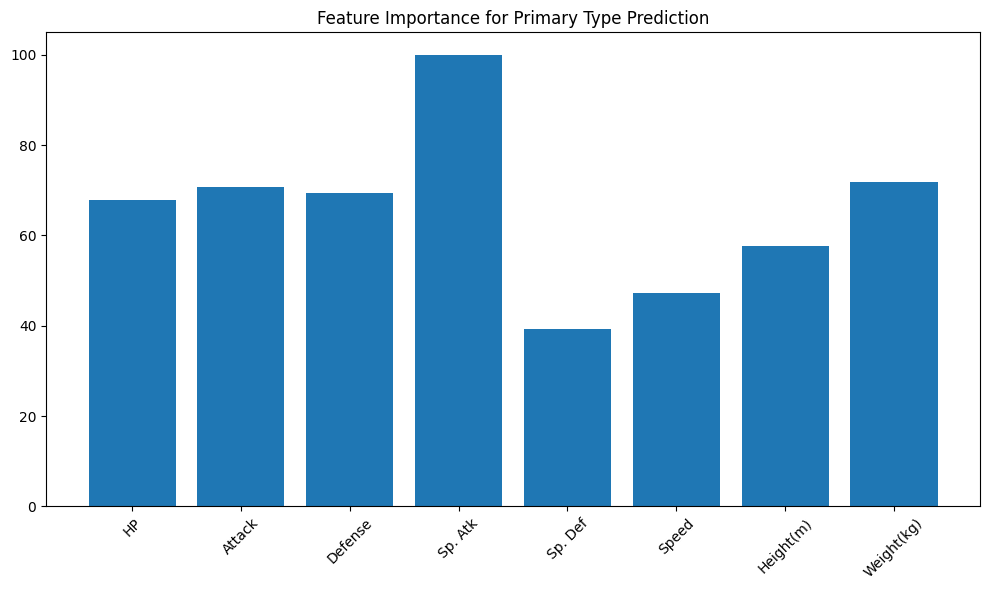

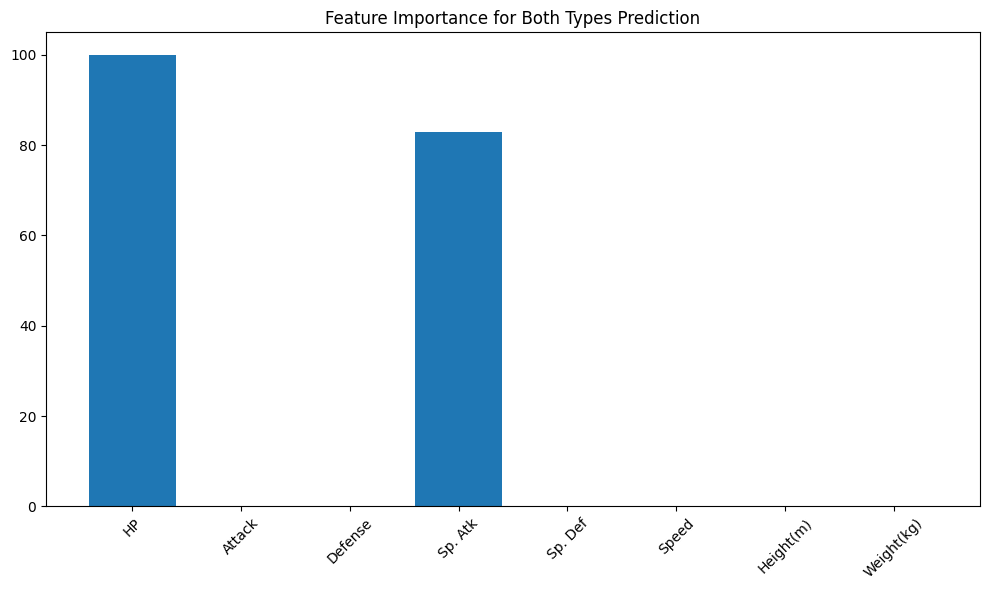

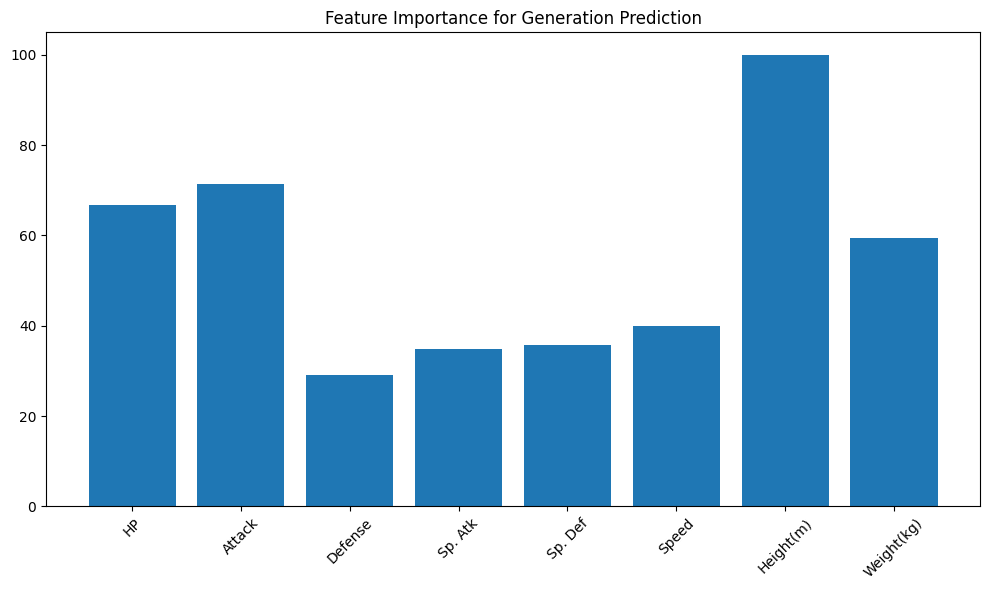

In [ ]:
import matplotlib.pyplot as plt

# Primary Type Feature Importance
primary_importance = np.abs(grid_search_primary.best_estimator_.coef_).mean(axis=0)
primary_importance = 100.0 * (primary_importance / primary_importance.max())

plt.figure(figsize=(10, 6))
plt.bar(features, primary_importance)
plt.title('Feature Importance for Primary Type Prediction (LR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Both Types Feature Importance
both_importance = np.abs(grid_search_both.best_estimator_.estimators_[0].coef_).mean(axis=0)
both_importance = 100.0 * (both_importance / both_importance.max())

plt.figure(figsize=(10, 6))
plt.bar(features, both_importance)
plt.title('Feature Importance for Both Types Prediction (LR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Generation Feature Importance
gen_importance = np.abs(grid_search_gen.best_estimator_.coef_).mean(axis=0)
gen_importance = 100.0 * (gen_importance / gen_importance.max())

plt.figure(figsize=(10, 6))
plt.bar(features, gen_importance)
plt.title('Feature Importance for Generation Prediction (LR)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Post Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data with engineered features
train_df = pd.read_csv('engineered_csv/pokemon_train_engineered.csv')
test_df = pd.read_csv('engineered_csv/pokemon_test_engineered.csv')

# Define original and engineered features
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

# Combine original and engineered features
all_features = original_features + engineered_features

# Prepare features
X_train = train_df[all_features]
X_test = test_df[all_features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("Training set shape:", X_train_final.shape)
print("Test set shape:", X_test_final.shape)
print("Number of classes for multi-label classification:", len(mlb.classes_))

Training set shape: (820, 35)
Test set shape: (205, 35)
Number of classes for multi-label classification: 18


In [2]:
# Baseline without CV
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss

# Primary Type
lr_primary = LogisticRegression(max_iter=1000)
lr_primary.fit(X_train_final, y_train_primary)
y_pred_primary = lr_primary.predict(X_test_final)
print("Logistic Regression - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
lr_both = MultiOutputClassifier(LogisticRegression(max_iter=1000))
lr_both.fit(X_train_final, y_train_both_bin)
y_pred_both = lr_both.predict(X_test_final)
print("Logistic Regression - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Generation
lr_generation = LogisticRegression(max_iter=1000)
lr_generation.fit(X_train_final, y_train_generation)
y_pred_generation = lr_generation.predict(X_test_final)
print("Logistic Regression - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

Logistic Regression - Primary Type Accuracy: 0.23902439024390243
Logistic Regression - Both Types Hamming Loss: 0.0883468834688347
Logistic Regression - Generation Accuracy: 0.2926829268292683


## Visualizations

In [ ]:
# NEED TO MAKE COMPATIBLE WITH THE CELLS RUN ABOVE OR MOVE THEM BACK UP 
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each primary type in the test set
primary_type_counts = y_test_primary_type.value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=primary_type_counts.index, y=primary_type_counts.values, color="skyblue")
plt.title('Distribution of Primary Pokemon Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.legend(['Count'])
plt.grid(True)
plt.show()

from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_primary_type, lr_predictions_primary)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=primary_type_counts.index, yticklabels=primary_type_counts.index)
plt.title('Confusion Matrix for Primary Type Predictions')
plt.xlabel('Predicted Type')
plt.ylabel('True Type')
plt.show()
import matplotlib.pyplot as plt
import numpy as np

# Assuming lr_model_primary is your trained OneVsRestClassifier for primary type prediction
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']

# Initialize an array to store the average absolute coefficients
avg_coef = np.zeros(len(features))

# Iterate through all estimators (one for each class)
for estimator in lr_model_primary.estimators_:
    avg_coef += np.abs(estimator.coef_[0])

# Calculate the average
avg_coef /= len(lr_model_primary.estimators_)

# Sort features by importance (average absolute value of coefficients)
sorted_idx = np.argsort(avg_coef)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(features)[sorted_idx], avg_coef[sorted_idx], color='skyblue')
plt.xlabel('Average Absolute Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance from Logistic Regression (Primary Type)')
plt.grid(True)
plt.show()
# Calculate Hamming loss per sample (number of incorrect labels per sample)
incorrect_labels_per_sample = np.sum(np.abs(y_test_both_types_bin - lr_predictions_both), axis=1)

# Plot Hamming loss distribution
plt.figure(figsize=(8, 6))
sns.histplot(incorrect_labels_per_sample, bins=np.arange(0, 3), kde=False, color='peachpuff')
plt.title('Distribution of Incorrect Labels per Sample (Hamming Loss)')
plt.xlabel('Number of Incorrect Labels')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
from sklearn.metrics import precision_recall_curve

# Precision-Recall curve for each label (type)
for i in range(len(mlb.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_both_types_bin[:, i], lr_model_both.predict_proba(X_test_scaled)[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {mlb.classes_[i]}')

# Plot settings
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Each Type")
plt.legend(loc="best")
plt.grid(True)
plt.show()

from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Count true type combinations
true_combinations = Counter([tuple(sorted(filter(None, t))) for t in y_test_both_types])

# For predicted combinations, we need to convert the binary predictions back to labels
predicted_types = mlb.inverse_transform(lr_predictions_both)
predicted_combinations = Counter([tuple(sorted(filter(None, t))) for t in predicted_types])

# Create a set of all unique combinations
all_combinations = set(true_combinations.keys()) | set(predicted_combinations.keys())

# Create a DataFrame with all combinations and fill in the counts
combinations_df = pd.DataFrame({
    'True': [true_combinations.get(comb, 0) for comb in all_combinations],
    'Predicted': [predicted_combinations.get(comb, 0) for comb in all_combinations]
}, index=list(all_combinations))

# Sort the DataFrame by the sum of True and Predicted counts
combinations_df['Total'] = combinations_df['True'] + combinations_df['Predicted']
combinations_df = combinations_df.sort_values('Total', ascending=False).drop('Total', axis=1)

# Select top N combinations for better visibility
top_n = 20  # Adjust this value to show more or fewer combinations
combinations_df = combinations_df.head(top_n)

# Plot bar chart of type combinations
ax = combinations_df.plot(kind='bar', figsize=(15, 8), color=['skyblue', 'peachpuff'])
plt.title(f'Top {top_n} True vs Predicted Type Combinations')
plt.xlabel('Type Combination')
plt.ylabel('Count')
plt.legend(['True', 'Predicted'])
plt.grid(True, axis='y')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Add value labels on the bars
for i, (index, row) in enumerate(combinations_df.iterrows()):
    ax.text(i, row['True'], str(int(row['True'])), ha='center', va='bottom')
    ax.text(i, row['Predicted'], str(int(row['Predicted'])), ha='center', va='bottom')

plt.show()

NameError: name 'y_test_primary_type' is not defined

## EXTRA CODE

In [ ]:
# MIGHT NOT BE RELEVANT 
# Cross validation ON ENTIRE DATASET + Evaluation + Analyze Misclassifications
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, hamming_loss, f1_score
from collections import Counter

# Load data
df = pd.read_csv('csv/pokemon.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X = df[features]
y_primary = df['Primary_Type']

# Prepare both types for multi-label classification
y_both = df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_both]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_both_bin = mlb.fit_transform(y_both)

# Set up k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Primary Type Prediction
lr_primary = LogisticRegression(max_iter=1000)
scores_primary = cross_val_score(lr_primary, X_scaled, y_primary, cv=kf, scoring='accuracy')

print("Primary Type Prediction:")
print(f"Cross-validation scores: {scores_primary}")
print(f"Mean CV score: {scores_primary.mean():.3f} (+/- {scores_primary.std() * 2:.3f})")

# Both Types Prediction
lr_both = OneVsRestClassifier(LogisticRegression(max_iter=1000))

def hamming_score(y_true, y_pred):
    return 1 - hamming_loss(y_true, y_pred)

hamming_scorer = make_scorer(hamming_score)

scores_both = cross_val_score(lr_both, X_scaled, y_both_bin, cv=kf, scoring=hamming_scorer)

print("\nBoth Types Prediction:")
print(f"Cross-validation scores: {scores_both}")
print(f"Mean CV score: {scores_both.mean():.3f} (+/- {scores_both.std() * 2:.3f})")

# Exact Match Ratio and F1 Score for Both Types
y_pred_both = cross_val_predict(lr_both, X_scaled, y_both_bin, cv=kf)
exact_match_ratio = accuracy_score(y_both_bin, y_pred_both)
f1 = f1_score(y_both_bin, y_pred_both, average='micro')

print(f"\nExact Match Ratio: {exact_match_ratio:.4f}")
print(f"F1 Score (micro-averaged): {f1:.4f}")

# Misclassification Analysis
y_pred_labels = mlb.inverse_transform(y_pred_both)
misclassifications = [(true, pred) for true, pred in zip(y_both, y_pred_labels) if set(true) != set(pred)]

print("\nSome misclassifications:")
for i, (true, pred) in enumerate(misclassifications[:5]):  # Print first 5 misclassifications
    print(f"Example {i+1}:")
    print(f"True Types: {true}")
    print(f"Predicted Types: {pred}")
    print()

true_types = Counter([type for types, _ in misclassifications for type in types])
pred_types = Counter([type for _, types in misclassifications for type in types])

print("Most common true types in misclassifications:")
print(true_types.most_common(5))

print("\nMost common predicted types in misclassifications:")
print(pred_types.most_common(5))

# Train final models on full dataset
lr_primary_final = LogisticRegression(max_iter=1000)
lr_primary_final.fit(X_scaled, y_primary)

lr_both_final = OneVsRestClassifier(LogisticRegression(max_iter=1000))
lr_both_final.fit(X_scaled, y_both_bin)

print("\nFeature Importance for Primary Type Prediction:")
feature_importance = np.abs(lr_primary_final.coef_).mean(axis=0)
for f, imp in sorted(zip(features, feature_importance), key=lambda x: x[1], reverse=True):
    print(f"{f}: {imp:.4f}")

In [ ]:
# Examining the model

# Predict probabilities for both types
y_pred_proba = cross_val_predict(lr_both, X_scaled, y_both_bin, cv=kf, method='predict_proba')

# Function to convert probabilities to predictions with a custom threshold
def custom_predict(probas, threshold=0.5):
    return (probas >= threshold).astype(int)

# Function to evaluate predictions
def evaluate_predictions(y_true, y_pred, threshold):
    exact_match_ratio = accuracy_score(y_true, y_pred)
    hamming_loss_value = hamming_loss(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='micro')
    
    print(f"\nResults with threshold {threshold}:")
    print(f"Exact Match Ratio: {exact_match_ratio:.4f}")
    print(f"Hamming Loss: {hamming_loss_value:.4f}")
    print(f"F1 Score (micro-averaged): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Evaluate with different thresholds
thresholds = [0.5, 0.3, 0.1]
for threshold in thresholds:
    y_pred_custom = custom_predict(y_pred_proba, threshold)
    evaluate_predictions(y_both_bin, y_pred_custom, threshold)

# Print raw probabilities for a few examples
print("\nRaw prediction probabilities for the first 5 examples:")
for i in range(5):
    print(f"\nExample {i+1}:")
    print(f"True Types: {y_both[i]}")
    for j, prob in enumerate(y_pred_proba[i]):
        if prob > 0.01:  # Only print probabilities > 1%
            print(f"{mlb.classes_[j]}: {prob:.4f}")

# Misclassification Analysis (using the 0.5 threshold as an example)
y_pred_labels = mlb.inverse_transform(custom_predict(y_pred_proba, 0.5))
misclassifications = [(true, pred) for true, pred in zip(y_both, y_pred_labels) if set(true) != set(pred)]

print("\nSome misclassifications:")
for i, (true, pred) in enumerate(misclassifications[:5]):  # Print first 5 misclassifications
    print(f"Example {i+1}:")
    print(f"True Types: {true}")
    print(f"Predicted Types: {pred}")
    print()

true_types = Counter([type for types, _ in misclassifications for type in types])
pred_types = Counter([type for _, types in misclassifications for type in types])

print("Most common true types in misclassifications:")
print(true_types.most_common(5))

print("\nMost common predicted types in misclassifications:")
print(pred_types.most_common(5))

# Train final model on full dataset for feature importance
lr_primary_final = LogisticRegression(max_iter=1000)
lr_primary_final.fit(X_scaled, y_primary)

print("\nFeature Importance for Primary Type Prediction:")
feature_importance = np.abs(lr_primary_final.coef_).mean(axis=0)
for f, imp in sorted(zip(features, feature_importance), key=lambda x: x[1], reverse=True):
    print(f"{f}: {imp:.4f}")